# Neural network - made by Dylan DO AMARAL

In [24]:
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [25]:
# Constant
PERCENTAGE_TRAINING = 80                          # Percentage of the data taken for training only
PERCENTAGE_TESTINT  = 100 - PERCENTAGE_TRAINING   # Percentage of the data taken for testing only
MINI_MSE            = 0.0001                      # Stop condition for our model if it reach this minimum MSE
MAX_ITERATION       = 1000000                     # Max number of iteration if the model don't reach the minimum MSE and if the epoch is too big
EPOCH               = 20                          # Number of epoch to train our mode

## Prepare the training data

In [26]:
#observed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#observed = [0, 2, 4, 6, 8] #Odd
#observed = [1, 3, 5, 7, 9] #Even
observed = [2, 3, 8, 9] #Test

# Convert a number into an array compatible with our neural network according to observed define above
# Example :
#    observed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#          3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# Parameter :
#    n: number -> number that need to be converted
# Return :
#    y: list   -> number inside the matrix space
def numberToArray(n):
    res = [0] * len(observed);
    res[observed.index(n)] = 1
    return res

# Reverse the numberToArray process
# Example :
#    observed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#               [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] -> 3 
# Parameter :
#    n: list   -> list that need to be converted
# Return :
#    y: number -> real number
def arrayToNumber(n):
    return observed[n.index(1)]

In [27]:
# Read data
data = list()
for i in range(0, 10):
    if i not in observed:
        continue
    for filename in glob.glob('./training/' + str(i) + '/*.png'):
        image = mpimg.imread(filename)
        data.append((image.flatten(), numberToArray(i)))

In [28]:
# Shuffle data and separe in two sets
random.shuffle(data)

training = data[0:int(PERCENTAGE_TRAINING * len(data) / 100)]
testing  = data[int(PERCENTAGE_TRAINING * len(data) / 100):len(data)]

print("training length : ", len(training))
print("testing length  : ", len(testing))

training length :  12800
testing length  :  3200


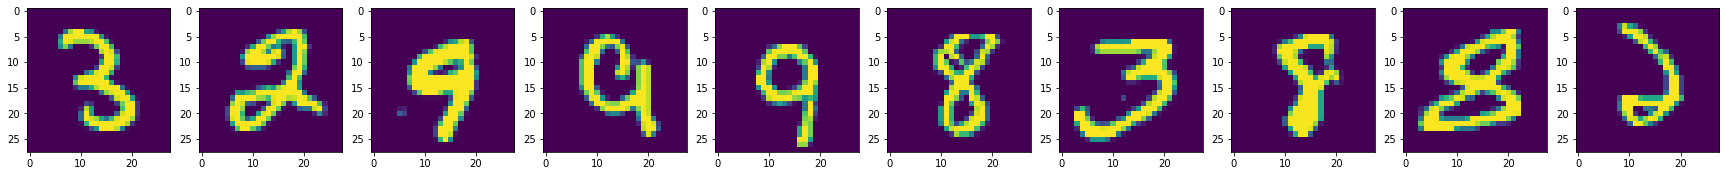

In [29]:
# Show some sample of our data
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20,20))
plt.subplots_adjust(right = 1.3)

count = 0
for ax in axs.flat:
    ax.imshow(data[count][0].reshape(28, 28))
    count += 1

## Create NN system

In [30]:
# Sigmoid function
# 
# Parameter :
#    x: number or matrix -> number that need to be sigmoidfied
# Return :
#    y: number or matrix -> Sigmoid of x
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [31]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers        = layers
        self.n_layers      = len(layers)
        self.learning_rate = 0.01
        self.neurons       = [np.zeros((self.layers[l], 1)) for l in range(0, self.n_layers)]
        self.biases        = [np.random.uniform(-0.5, 0.5, (self.layers[l], 1)) for l in range(1, self.n_layers)]
        self.weights       = [np.random.uniform(-0.5, 0.5, (self.layers[l], self.layers[l - 1])) for l in range(1, self.n_layers)]
        self.iteration     = 0
        self.SEs           = list()
        self.MSEs          = list()

    # Feed forward algorighm that update every weight of our network according to the "entry", an array that represent
    # the first layer
    # 
    # Parameter :
    #    entry: list -> Array representing value that enter inside the network
    # Return :
    #    None
    def feedforward(self, entry):
        self.neurons[0] = np.matrix(entry).T
        for layer in range(1, self.n_layers):
            self.neurons[layer] = sigmoid(self.weights[layer - 1] * self.neurons[layer - 1] + self.biases[layer - 1])
        
    # Backpropagate an error caused by the difference between the target and the last layer
    # 
    # Parameter :
    #    target: list -> Value that should be predicted by the network
    # Return :
    #    None
    def backpropagation(self, target):        
        gradients = [None for w in self.weights]
        for i in range(self.n_layers - 1, 0, -1):
            sigmoid_prime = np.multiply(self.neurons[i], 1 - self.neurons[i])
            if i == self.n_layers - 1:
                error = np.matrix(target).T - self.neurons[i]
            else:
                error = np.dot(self.weights[i].T, error)
            gradients[i - 1] = np.multiply(error, sigmoid_prime)
        for i in range(0, self.n_layers - 1):
            if self.iteration % 1000 == 0:
                self.learning_rate *= 0.9999
            self.weights[i] = self.weights[i] + self.learning_rate * np.dot(gradients[i], self.neurons[i].T)
            self.biases[i]  = self.biases[i]  + self.learning_rate * gradients[i]
    
    # The current squared error divide by the number of output
    # 
    # Parameter :
    #    target: list -> Value that should be predicted by the network
    # Return :
    #    SE: int      -> The squared error
    def MSE(self, target):
        return (1 / len(target)) * sum((target - self.neurons[-1].A1) ** 2)
    
    # Train the neural network according to a set of data
    # 
    # Parameter :
    #    data: list(list, list) -> List of tuple containing n training data where the first element is the entry and the last the target
    # Return :
    #    None
    def train(self, data):
        n = 0
        e = 0
        for e in range(0, EPOCH):
            print("epoch number " + str(e))
            self.iteration += 1
            random.shuffle(data)
            for i in range(0, len(data)):
                if n > MAX_ITERATION:
                    break;
                (entry, target) = data[i]
                self.feedforward(entry)
                self.SEs.append(float(self.MSE(target)))
                self.MSEs.append((1 / len(self.SEs)) * sum(self.SEs))
                if self.MSEs[-1] < MINI_MSE:
                    break;
                self.backpropagation(target)
                n += 1
    
    # Predict the value of an entry
    # 
    # Parameter :
    #    entry: list -> Array representing value that enter inside the network
    # Return :
    #    value: int  -> Predicted value
    def predict(self, entry):
        self.feedforward(entry)
        index = -1
        score = 0
        for i in range(0, len(self.neurons[-1])):
            if self.neurons[-1].A1[i] > score:
                index = i
                score = self.neurons[-1].A1[i]
        return observed[index]

    def show(self):
        for i in range(0, self.n_layers):
            print("neuron's layer", i, ":\n", self.neurons[i])
        for i in range(0, self.n_layers - 1):
            print("weight's layer", i, ":\n", self.weights[i])

## Train the network

In [ ]:
#nn = NeuralNetwork([28 * 28, 128, 64, len(observed)])
nn = NeuralNetwork([28 * 28, 128, len(observed)])

nn.train(training)

epoch number 0
epoch number 1
epoch number 2
epoch number 3
epoch number 4
epoch number 5
epoch number 6
epoch number 7
epoch number 8
epoch number 9
epoch number 10
epoch number 11
epoch number 12
epoch number 13
epoch number 14
epoch number 15
epoch number 16
epoch number 17
epoch number 18
epoch number 19


In [ ]:
# Error of our network according to the number of iteration
plt.plot(range(0, len(nn.MSEs)), nn.MSEs);

## Test with the test set

In [ ]:
# Check the accuracy of our algorithm using testing data
bad  = 0
good = 0
bads = list()
for test in testing:
    predict = nn.predict(test[0])
    if predict == arrayToNumber(test[1]):
        good += 1
    else:
        bad += 1
        bads.append((test[0], arrayToNumber(test[1]), predict))

print("Accuracy of the network :", (good) / (good + bad) * 100, "%")

In [ ]:
# Examples where the network failed to predict the correct answer
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(20, 7))
plt.subplots_adjust(right = 1.3)

random.shuffle(bads)

count = 0
for ax in axs.flat:
    ax.imshow(bads[count][0].reshape(28, 28))
    ax.set_title(str(bads[count][2]) + " should be " + str(bads[count][1]), fontsize = 16)
    count += 1

## Output the result

In [23]:
# Read files from "Testing data" files and try to predict for each one the value inside a file named "output"
f = open("output.txt", "w") 
for filename in glob.glob('E:/testing/*.png'):
    image  = mpimg.imread(filename)
    name = filename.split("\\")[-1].split(".png")[0]
    result = nn.predict(image.flatten())
    f.write(name + " " + str(result) + "\n")
f.close()